Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [192]:
import os
import pandas as pd
import numpy as np
import sys
import os
def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.crawler.fifa import extract_attributes


New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


### Get Data

In [193]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_prospect = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT MAX(Potential) as max_potential, * FROM fifa  GROUP BY ID )
GROUP BY ID
order by max_potential DESC
"""


In [194]:
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)

df_prospect = pd.read_sql_query(sql_prospect, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_prospect = df_prospect.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])
df_raw = df_prospect.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID']).set_index(['ID','Name','FIFA'])


df_raw.head()

,,,potential_age,max_potential,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Position,Unnamed: 0,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Composure,Defensive awareness,prime_age,PrimeOverall
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2014,26.0,97.0,26.0,https://cdn.sofifa.net/players/158/023/14_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,94.0,97.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€78M,€450K,2173.0,CF,10273.0,84.0,97.0,71.0,89.0,90.0,97.0,87.0,86.0,76.0,96.0,96.0,90.0,94.0,96.0,95.0,81.0,73.0,78.0,60.0,88.0,48.0,22.0,93.0,90.0,76.0,25.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,NaN,NaN,24.0,94.0
231747,K. Mbappé,2020,20.0,95.0,20.0,https://cdn.sofifa.net/players/231/747/20_60.png,France,https://cdn.sofifa.net/flags/fr.png,89.0,95.0,Paris Saint Germain,https://cdn.sofifa.net/meta/team/591/30.png,€93.5M,€150K,2133.0,"ST,RW",12588.0,78.0,89.0,77.0,82.0,79.0,91.0,79.0,63.0,70.0,90.0,96.0,96.0,92.0,89.0,83.0,83.0,76.0,84.0,76.0,79.0,62.0,38.0,89.0,80.0,70.0,NaN,34.0,32.0,13.0,5.0,7.0,11.0,6.0,84.0,34.0,22.0,91.0
190871,Neymar,2017,24.0,95.0,24.0,https://cdn.sofifa.net/players/190/871/17_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,92.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€109M,€450K,2077.0,LW,17441.0,75.0,89.0,62.0,81.0,83.0,96.0,78.0,79.0,75.0,95.0,93.0,90.0,96.0,88.0,82.0,78.0,61.0,70.0,49.0,77.0,56.0,36.0,90.0,80.0,81.0,21.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,80.0,NaN,24.0,92.0
20801,Cristiano Ronaldo,2014,28.0,95.0,28.0,https://cdn.sofifa.net/players/020/801/14_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,92.0,95.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€56M,€325K,2220.0,"LW,LM",10272.0,83.0,92.0,86.0,82.0,85.0,90.0,88.0,79.0,72.0,95.0,91.0,94.0,93.0,90.0,75.0,94.0,94.0,89.0,79.0,93.0,63.0,24.0,89.0,81.0,85.0,22.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,NaN,NaN,31.0,94.0
239085,E. Haaland,2023,21.0,94.0,21.0,https://cdn.sofifa.net/players/239/085/23_60.png,Norway,https://cdn.sofifa.net/flags/no.png,88.0,94.0,Manchester City,https://cdn.sofifa.net/meta/team/9/30.png,€148M,€220K,2120.0,ST,12459.0,47.0,94.0,79.0,74.0,88.0,78.0,77.0,62.0,53.0,82.0,82.0,94.0,76.0,88.0,72.0,94.0,74.0,81.0,93.0,87.0,85.0,43.0,89.0,74.0,76.0,NaN,53.0,29.0,7.0,14.0,13.0,11.0,7.0,85.0,44.0,22.0,91.0


In [195]:
best_pos = lambda x: x.split(',')[0]

# Apply the lambda function to add best position
df_raw["best_position"] = df_raw['Position'].apply(best_pos)
df_raw["best_position"].value_counts()

best_position
CB     9791
ST     8957
CM     6622
GK     6586
CDM    4442
RB     4028
LB     3993
CAM    3858
RM     3106
LM     2995
RW     1503
LW     1342
CF      838
RWB     398
LWB     382
RF       72
LF       66
SW        8
Name: count, dtype: int64

In [196]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'test', 2020: 'test', 2021: 'test', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Overall<83)&(df.Age<26)&(df.Potential>83)]

In [197]:

df = df[df.prime_age>df.potential_age]
df = df[(df.Potential>83)]
df['target'] = ((df.max_potential>83)&(df.PrimeOverall<83))
df = df[df.potential_age<26]
df.target.value_counts()


df_processed = df.copy()

In [198]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set
ID,Name,FIFA,,,,,,,,,
231747,K. Mbappé,2020,20.0,20.0,22.0,95.0,95.0,89.0,91.0,False,test
239085,E. Haaland,2023,21.0,21.0,22.0,94.0,94.0,88.0,91.0,False,valid
230621,G. Donnarumma,2018,18.0,18.0,22.0,94.0,94.0,82.0,89.0,False,train
242444,João Félix,2020,19.0,19.0,22.0,93.0,93.0,80.0,84.0,False,test
200389,J. Oblak,2018,24.0,24.0,26.0,93.0,93.0,88.0,91.0,False,train


In [199]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

## Deskriptive Analyse

In [200]:
df.select_dtypes(exclude='object').corr()['target'].round(2).sort_values().head()

PrimeOverall    -0.69
Overall         -0.61
max_potential   -0.51
Potential       -0.51
Reactions       -0.51
Name: target, dtype: float64

In [201]:
df[df.target].describe().round(3)
pd.set_option('display.max_columns', 3000)
df[df.target].describe().round(3).compare(df[~df.target].describe().round(3))



potential_age          max_potential               Age           \
               self    other          self    other     self    other   
count       736.000  207.000       736.000  207.000  736.000  207.000   
mean         20.461   22.691        85.279   87.643   20.461   22.691   
std           2.096    1.872         1.373    2.331    2.096    1.872   
min          16.000   18.000           NaN      NaN   16.000   18.000   
25%          19.000   22.000        84.000   86.000   19.000   22.000   
50%          20.000   23.000        85.000   87.000   20.000   23.000   
75%          22.000   24.000        86.000   89.000   22.000   24.000   
max             NaN      NaN        90.000   95.000      NaN      NaN   

       Overall          Potential            Special           Unnamed: 0  \
          self    other      self    other      self     other       self   
count  736.000  207.000   736.000  207.000   736.000   207.000    736.000   
mean    73.110   81.217    85.279   87.643  1778.749  1942.556  10480.285   
std      4.642    3.338     1.373    2.331   213.549   233.762   2491.137   
min     59.000   69.000       NaN      NaN   903.000  1158.000   2018.000   
25%     70.000   80.000    84.000   86.000  1671.750  1890.500   9185.000   
50%     74.000   81.000    85.000   87.000  1805.000  1982.000  10562.000   
75%     77.000   83.000    86.000   89.000  1923.500  2085.500  11986.250   
max     81.000   89.000    90.000   95.000  2193.000  2295.000  17148.000   

                 Crossing          Finishing          HeadingAccuracy  \
           other     self    other      self    other            self   
count    207.000  736.000  207.000   736.000  207.000         736.000   
mean   12265.343   58.376   64.643    56.163   61.010          57.010   
std     2426.579   16.638   19.018    18.774   21.751          15.922   
min     8437.000    5.000    9.000     3.000    9.000             NaN   
25%    10587.500   51.000   59.500    45.000   49.500          48.000   
50%    11312.000   63.000   70.000    62.000   68.000          59.000   
75%    12740.000   70.000   77.000    70.000   77.000          69.000   
max    17433.000   88.000   91.000    87.000   94.000          86.000   

               ShortPassing           Volleys          Dribbling           \
         other         self    other     self    other      self    other   
count  207.000      736.000  207.000  736.000  207.000   736.000  207.000   
mean    62.188       68.022   74.618   52.440   59.367    67.711   72.391   
std     19.125       12.048   14.340   16.883   20.577    17.231   20.150   
min        NaN       11.000   14.000    4.000    8.000     7.000    9.000   
25%     52.000       64.000   74.000   42.000   47.000    65.000   70.000   
50%     67.000       70.000   78.000   56.000   66.000    73.000   79.000   
75%     76.000       76.000   83.000   65.000   75.500    78.000   85.000   
max     92.000       88.000   93.000   84.000   91.000    91.000   92.000   

         Curve          FKAccuracy          LongPassing          BallControl  \
          self    other       self    other        self    other        self   
count  736.000  207.000    736.000  207.000     736.000  207.000     736.000   
mean    56.995   64.560     49.774   57.155      60.732   68.599      70.177   
std     17.328   20.487     16.981   19.858      13.653   14.880      13.810   
min      5.000    7.000      4.000    8.000      11.000   12.000      10.000   
25%     48.000   57.500     38.000   45.500      53.000   63.500      68.000   
50%     61.500   72.000     51.000   62.000      64.000   73.000      73.000   
75%     69.000   79.000     62.000   73.000      71.000   78.000      78.000   
max     89.000   87.000     91.000   90.000      85.000   92.000      87.000   

               Acceleration          SprintSpeed           Agility           \
         other         self    other        self    other     self    other   
count  207.000      736.000  207.000     73

###  Feature Engineering

In [202]:
PLAYER_ATTRIBUTES = [ 'Age','Finishing','Crossing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Aggression',  'Positioning', 'Vision', 'Penalties', 
                      ]
PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [ 'Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
# PLAYER_ATTRIBUTES = [ 'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance',  'Jumping', 'Stamina', 'Strength',  'Aggression', 'Positioning', 'Vision']

#### Transform Defense Attributs

In [203]:

if False:
    df['Defense'] =  df['Defensive awareness'].fillna(0)+df['Marking'].fillna(0)
    df_potentials['Defense'] =  df_potentials['Defensive awareness'].fillna(0)+df_potentials['Marking'].fillna(0)
    PLAYER_ATTRIBUTES.append('Defense')


#### Transform Value

In [204]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

In [205]:
df['target'].value_counts()

target
True     736
False    207
Name: count, dtype: int64

In [206]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [207]:


from sklearn.model_selection import train_test_split
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [208]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

import pandas as pd

from sklearn.preprocessing import StandardScaler
# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

In [209]:
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
import xgboost as xgb
import lightgbm as lgb
import warnings
import shap 
import shap  # For SHAP values
import pickle

# Define class weights (if applicable)
class_weights = 'balanced'  # You can customize these weights if needed

# Create and train different classification models with class weights
models = {
    # 'Logistic Regression': LogisticRegression(class_weight=class_weights),
    # 'Decision Tree Classifier': DecisionTreeClassifier(class_weight=class_weights),
    # 'Random Forest Classifier': RandomForestClassifier(class_weight=class_weights),
    # 'Support Vector Classifier': SVC(class_weight=class_weights,probability=True,kernel='linear'),
    'XGBoost Classifier': xgb.XGBClassifier(),
    'LightGBM Classifier': lgb.LGBMClassifier()
}

model_results = {}

for model_name, model in models.items():
    print(model_name,"training----->")
    model.fit(X_train_scaled_df, y_train)
    y_pred = model.predict(X_test_scaled_df)
    
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test_scaled_df)[:, 1]
    else:
        y_prob = None
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    if y_prob is not None:
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = None
    
    precision = precision_score(y_test, y_pred)
    
    model_results[model_name] = {
        'Model': model,
        'Accuracy': accuracy,
        'Classification Report': report,
        'Confusion Matrix': conf_matrix,
        'AUC': auc,
        'Precision': precision
    }
    if False:
        try:
            # Interpret the model using SHAP values
            explainer = shap.Explainer(model)
            shap_values = explainer(X_test_scaled_df)
            # Save SHAP values to a pickle file
            with open(f"{model_name}_shap_values.pkl", "wb") as file:
                pickle.dump(shap_values, file)
        except:
            print("Fehler bei SHAP",model_name)

# Evaluate and print results for each model
for model_name, results in model_results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {results['Accuracy']:.2f}")
    print("Classification Report:")
    print(results['Classification Report'])
    print("Confusion Matrix:")
    print(results['Confusion Matrix'])
    if results['AUC'] is not None:
        print(f"AUC: {results['AUC']:.2f}")
    if 'Precision' in results:
        print(f"Precision: {results['Precision']:.2f}")
    print()


XGBoost Classifier training----->


LightGBM Classifier training----->
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 280, number of negative: 106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1672
[LightGBM] [Info] Number of data points in the train set: 386, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.725389 -> initscore=0.971351
[LightGBM] [Info] Start training from score 0.971351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

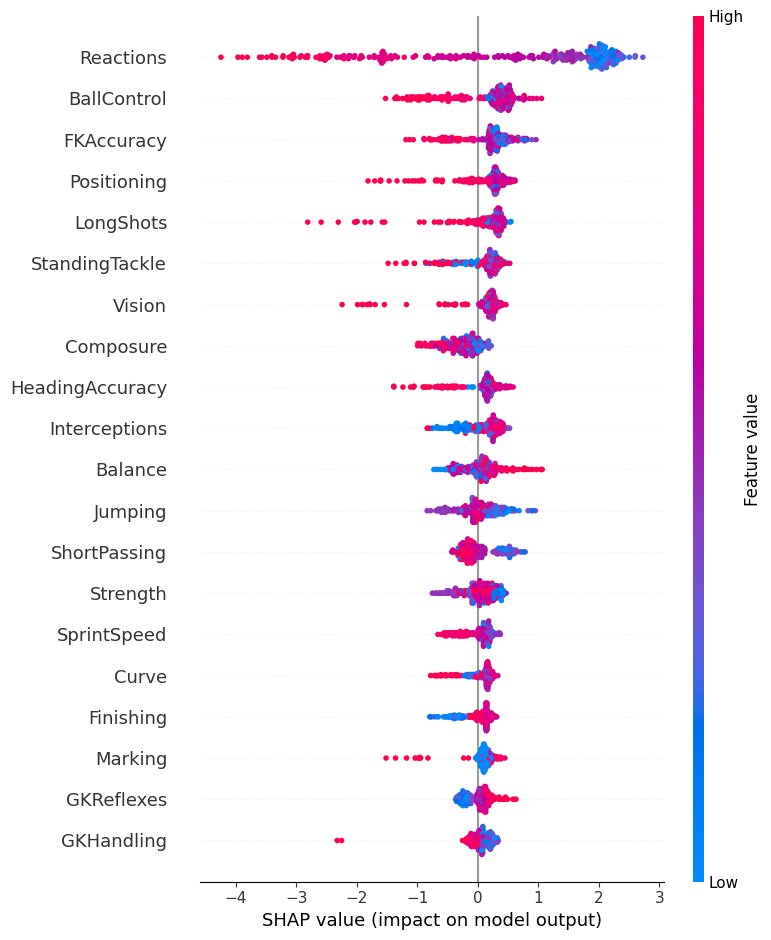

In [210]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test_scaled_df)
shap.summary_plot(shap_values[1], X_test_scaled_df)

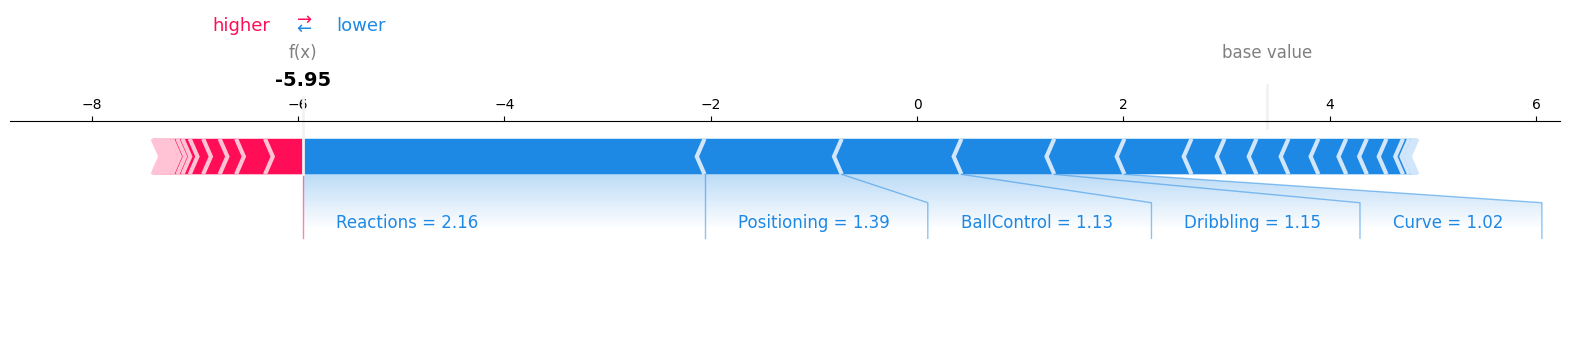

In [211]:
shap.plots.force(np.round(explainer.expected_value[1],2), np.round(shap_values[1][0,:],2), np.round(X_test_scaled_df.iloc[0, :],2), matplotlib = True)

In [212]:
from sklearn.metrics import precision_score
y_score = model.predict_proba(X_test_scaled_df)[:,1]>0.1
pre = np.round(precision_score(y_pred=y_score,y_true=y_test),3)
print("Potentials:",sum(y_score),"Precision:",pre,"------> Correct Potentials",pre*sum(y_score))
X_test[y_score]


Potentials: 265 Precision: 0.913 ------> Correct Potentials 241.94500000000002


,,,Age,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,GKPositioning,GKReflexes,Composure,Defensive awareness,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
241096,S. Tonali,2021,20.0,70.0,60.0,69.0,82.0,60.0,76.0,75.0,75.0,81.0,79.0,83.0,78.0,74.0,7.0,7.0,74.0,70.0,74.0,75.0,75.0,63.0,74.0,79.0,70.0,76.0,74.0,60.0,78.0,64.0,0.0,74.0,72.0,13.0,9.0,8.0
206585,Kepa,2019,23.0,25.0,11.0,17.0,32.0,18.0,10.0,25.0,19.0,36.0,16.0,34.0,33.0,41.0,80.0,84.0,63.0,0.0,79.0,39.0,25.0,71.0,37.0,51.0,14.0,18.0,21.0,15.0,55.0,24.0,19.0,18.0,16.0,84.0,80.0,76.0
253004,Ansu Fati,2021,17.0,69.0,75.0,58.0,72.0,59.0,79.0,64.0,45.0,69.0,77.0,89.0,87.0,89.0,10.0,7.0,73.0,23.0,70.0,82.0,67.0,73.0,64.0,48.0,70.0,48.0,19.0,68.0,67.0,74.0,0.0,32.0,28.0,6.0,9.0,8.0
235243,M. de Ligt,2019,18.0,57.0,53.0,79.0,75.0,40.0,64.0,48.0,55.0,72.0,69.0,62.0,68.0,58.0,12.0,10.0,74.0,0.0,75.0,59.0,83.0,80.0,74.0,87.0,61.0,78.0,78.0,44.0,63.0,40.0,80.0,81.0,77.0,12.0,11.0,11.0
230658,Arthur,2019,21.0,70.0,72.0,58.0,85.0,63.0,82.0,68.0,60.0,80.0,83.0,68.0,70.0,79.0,11.0,12.0,84.0,0.0,81.0,83.0,76.0,82.0,78.0,62.0,74.0,73.0,75.0,77.0,82.0,69.0,65.0,76.0,70.0,6.0,13.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213655,A. Iwobi,2019,22.0,58.0,63.0,42.0,81.0,48.0,82.0,50.0,40.0,61.0,83.0,81.0,78.0,77.0,14.0,11.0,70.0,0.0,74.0,76.0,67.0,50.0,73.0,72.0,54.0,46.0,24.0,68.0,76.0,56.0,30.0,26.0,23.0,14.0,7.0,12.0
213516,Ricardo Horta,2019,23.0,77.0,74.0,51.0,76.0,82.0,80.0,78.0,51.0,69.0,81.0,78.0,75.0,85.0,8.0,13.0,69.0,0.0,81.0,85.0,78.0,62.0,80.0,45.0,71.0,64.0,55.0,81.0,76.0,71.0,32.0,44.0,35.0,7.0,9.0,10.0
211515,P. Gollini,2020,24.0,17.0,14.0,19.0,31.0,20.0,18.0,13.0,15.0,25.0,24.0,46.0,48.0,56.0,76.0,78.0,63.0,20.0,72.0,52.0,50.0,52.0,40.0,68.0,17.0,19.0,18.0,12.0,30.0,21.0,0.0,12.0,19.0,77.0,72.0,67.0


In [213]:
%load_ext autoreload
%autoreload 2
from src.sport_analytics.model.eval import plot_feature_importance
if False:
    # Example usage:
    my_model = model_results['LightGBM Classifier']['Model']
    features = plot_feature_importance(my_model, 'LightGBM Classifier')

    my_model = model_results['Random Forest Classifier']['Model']
    features = plot_feature_importance(my_model, 'Random Forest Classifier')
    


    my_model = model_results['XGBoost Classifier']['Model']
    features = plot_feature_importance(my_model, 'XGBoost Classifier')

### evaluate test data

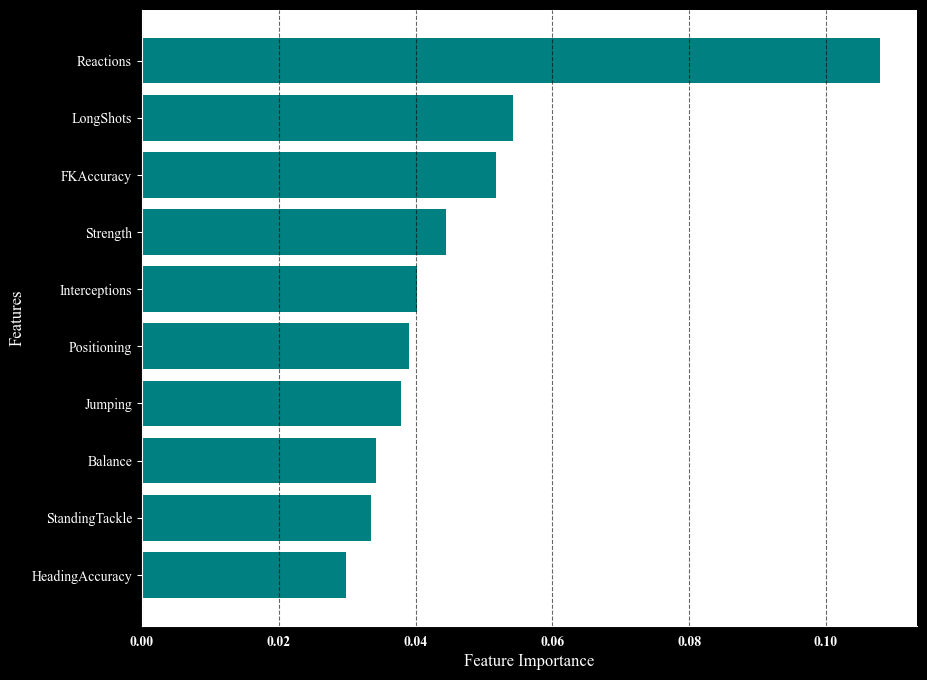

['Reactions',
 'LongShots',
 'FKAccuracy',
 'Strength',
 'Interceptions',
 'Positioning',
 'Jumping',
 'Balance',
 'StandingTackle',
 'HeadingAccuracy']

In [214]:
my_model = model_results['LightGBM Classifier']['Model']
features = plot_feature_importance(my_model, '')
features

In [215]:
import pickle

try:
    # Interpret the model using SHAP values
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    # Save SHAP values to a pickle file
    with open(f"{model_name}_shap_values.pkl", "wb") as file:
        pickle.dump(shap_values, file)
except:
    print("Fehler bei SHAP",model_name)

In [216]:
import tqdm
df_shap = pd.DataFrame()
i = 0
for i in range(len(shap_values.values)):
    df_shap[i] = shap_values.values[i][:,1]

df_shap = df_shap.T

In [217]:
my_model = model_results[ 'LightGBM Classifier']['Model']
y_pred = pd.DataFrame(my_model.predict_proba(X_test)[:,1],columns=["prediction"],index=y_test.index)

In [218]:
df_shap.index = X_test.index
df_shap.columns = X_test.columns
df_shap["SHAP"] = df_shap.T.sum().values

df_merge = pd.concat([y_pred,df_shap],axis=1)
df_merge = pd.concat([df['Overall'],df_merge],axis=1,join='inner')


In [219]:
df_merge = df_merge.sort_values(by="Aggression",ascending=False).round(3)
df_merge.head(10)

,,,Overall,prediction,Age,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,GKPositioning,GKReflexes,Composure,Defensive awareness,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,SHAP
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
237221,J. Foyth,2019,70.0,0.0,0.004,-0.196,-0.105,-0.405,-0.097,0.23,-1.185,-0.326,-0.307,-0.069,-0.931,0.012,-0.186,0.003,-0.096,0.159,-0.189,0.0,-3.447,0.608,-0.014,0.014,-0.025,0.139,-1.389,-0.275,-0.186,-0.615,-0.711,-0.011,-0.269,-0.475,-0.024,0.019,-0.584,-0.065,-10.994
210008,A. Rabiot,2019,83.0,0.0,0.004,-0.196,-0.105,-0.405,-0.097,0.23,-1.185,-0.326,-0.307,-0.069,-0.931,0.012,-0.186,0.003,-0.096,0.159,-0.189,0.0,-3.447,0.608,-0.014,0.014,-0.025,0.139,-1.389,-0.275,-0.186,-0.615,-0.711,-0.011,-0.269,-0.475,-0.024,0.019,-0.584,-0.065,-10.994
216201,Williams,2019,81.0,0.0,0.004,-0.196,-0.105,-0.405,-0.097,0.23,-1.185,-0.326,-0.307,-0.069,-0.931,0.012,-0.186,0.003,-0.096,0.159,-0.189,0.0,-3.447,0.608,-0.014,0.014,-0.025,0.139,-1.389,-0.275,-0.186,-0.615,-0.711,-0.011,-0.269,-0.475,-0.024,0.019,-0.584,-0.065,-10.994
224293,Rúben Neves,2019,79.0,0.0,0.004,-0.196,-0.105,-0.405,-0.097,0.23,-1.185,-0.326,-0.307,-0.069,-0.931,0.012,-0.186,0.003,-0.096,0.159,-0.189,0.0,-3.447,0.608,-0.014,0.014,-0.025,0.139,-1.389,-0.275,-0.186,-0.615,-0.711,-0.011,-0.269,-0.475,-0.024,0.019,-0.584,-0.065,-10.994
198717,W. Zaha,2019,82.0,0.0,0.004,-0.196,-0.105,-0.405,-0.097,0.23,-1.185,-0.326,-0.307,-0.069,-0.931,0.012,-0.186,0.003,-0.096,0.159,-0.189,0.0,-3.447,0.608,-0.014,0.014,-0.025,0.139,-1.389,-0.275,-0.186,-0.615,-0.711,-0.011,-0.269,-0.475,-0.024,0.019,-0.584,-0.065,-10.994
236295,Aarón Martín,2019,76.0,0.0,0.004,-0.196,-0.105,-0.405,-0.097,0.23,-1.185,-0.326,-0.307,-0.069,-0.931,0.012,-0.186,0.003,-0.096,0.159,-0.189,0.0,-3.447,0.608,-0.014,0.014,-0.025,0.139,-1.389,-0.275,-0.186,-0.615,-0.711,-0.011,-0.269,-0.475,-0.024,0.019,-0.584,-0.065,-10.994
211591,M. Dembélé,2019,75.0,0.0,0.004,-0.196,-0.105,-0.405,-0.097,0.23,-1.185,-0.326,-0.307,-0.069,-0.931,0.012,-0.186,0.003,-0.096,0.159,-0.189,0.0,-3.447,0.608,-0.014,0.014,-0.025,0.139,-1.389,-0.275,-0.186,-0.615,-0.711,-0.011,-0.269,-0.475,-0.024,0.019,-0.584,-0.065,-10.994
228881,D. Calabria,2019,77.0,0.0,0.004,-0.196,-0.105,-0.405,-0.097,0.23,-1.185,-0.326,-0.307,-0.069,-0.931,0.012,-0.186,0.003,-0.096,0.159,-0.189,0.0,-3.447,0.608,-0.014,0.014,-0.025,0.139,-1.389,-0.275,-0.186,-0.615,-0.711,-0.011,-0.269,-0.475,-0.024,0.019,-0.584,-0.065,-10.994
230938,F. Kessié,2019,78.0,0.0,0.004,-0.196,-0.105,-0.405,-0.097,0.23,-1.185,-0.326,-0.307,-0.069,-0.931,0.012,-0.186,0.003,-0.096,0.159,-0.189,0.0,-3.447,0.608,-0.014,0.014,-0.025,0.139,-1.389,-0.275,-0.186,-0.615,-0.711,-0.011,-0.269,-0.475,-0.024,0.019,-0.584,-0.065,-10.994


In [220]:
X_test[X_test.index == df_merge.index[0]]

,,,Age,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,GKPositioning,GKReflexes,Composure,Defensive awareness,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
237221,J. Foyth,2019,20.0,41.0,43.0,67.0,69.0,43.0,66.0,41.0,47.0,49.0,69.0,74.0,72.0,75.0,14.0,9.0,57.0,0.0,73.0,74.0,56.0,74.0,71.0,68.0,39.0,58.0,72.0,46.0,52.0,47.0,70.0,69.0,70.0,8.0,15.0,7.0


In [221]:
df_shap.sum()/(-df_shap['SHAP'].sum())

Age                    0.000442
Crossing              -0.017868
Finishing             -0.009830
HeadingAccuracy       -0.036951
ShortPassing          -0.008577
Volleys                0.020808
Dribbling             -0.108797
Curve                 -0.030481
FKAccuracy            -0.027500
LongPassing           -0.006216
BallControl           -0.084868
Acceleration           0.001111
SprintSpeed           -0.017360
Agility                0.000360
GKPositioning         -0.008654
GKReflexes             0.014505
Composure             -0.014469
Defensive awareness    0.000000
Reactions             -0.319790
Balance                0.054704
ShotPower             -0.001976
Jumping                0.001901
Stamina               -0.002429
Strength               0.012613
LongShots             -0.127157
Aggression            -0.025628
Interceptions         -0.016342
Positioning           -0.060314
Vision                -0.072446
Penalties             -0.001409
Marking               -0.002193
Standing

### predict potentials

In [232]:
df
prospects = pd.DataFrame(my_model.predict_proba(df_potentials_scaled_df)[:,1],columns=["prediction"],index=df_potentials.index)
# TODO: SHAP VALUES FOR
# df_potentials.to_csv('potentials.csv')
prospects.sort_values(by="prediction",ascending = True).head(30)

,,,prediction
ID,Name,FIFA,
234153,Carlos Soler,2022,0.005561
241637,A. Tchouaméni,2023,0.011913
240950,Pedro Gonçalves,2022,0.013794
257179,Gonçalo Inácio,2023,0.036548
233419,Raphinha,2022,0.059757
251470,C. De Ketelaere,2023,0.064121
229984,B. Chilwell,2022,0.067789
241461,Ferran Torres,2022,0.074558
243576,Pedro Porro,2023,0.078972


In [223]:
prospects[prospects.prediction>0.5]

,,,prediction
ID,Name,FIFA,
246104,R. Gravenberch,2022,0.936747
264240,Gavi,2023,0.884643
263578,Balde,2024,0.972108
259399,R. Højlund,2024,0.992320
258729,Gabri Veiga,2024,0.691581
...,...,...,...
235997,Fran Beltrán,2023,0.949042
233585,Lincoln,2023,0.998264
233096,D. Dumfries,2022,0.500789


In [224]:
df_prospect.loc[240243][["potential_age","max_potential"	,"Age","FIFA","Overall"]]

potential_age    21.0
max_potential    87.0
Age              21.0
FIFA             2021
Overall          78.0
Name: 240243, dtype: object

In [225]:
prospects.value_counts()

prediction
0.005561      1
0.999353      1
0.999428      1
0.999426      1
0.999425      1
             ..
0.972108      1
0.969905      1
0.969829      1
0.968610      1
0.999968      1
Name: count, Length: 348, dtype: int64

In [226]:
prospects.sort_values('prediction',ascending=False).round(3).value_counts()

prediction
1.000         102
0.999          45
0.998          25
0.997          14
0.996          11
             ... 
0.501           1
0.450           1
0.430           1
0.429           1
0.006           1
Name: count, Length: 122, dtype: int64